In [206]:
import pandas as pd
import numpy as np

## Introduction

Primeiro, importamos o código.

In [207]:
depression_df = pd.read_csv('Depression Professional Dataset.csv')

depression_df = depression_df.dropna()

depression_df

,Gender,Age,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work Hours,Financial Stress,Family History of Mental Illness,Depression
0,Female,37,2.0,4.0,7-8 hours,Moderate,No,6,2,No,No
1,Male,60,4.0,3.0,5-6 hours,Unhealthy,Yes,0,4,Yes,No
2,Female,42,2.0,3.0,5-6 hours,Moderate,No,0,2,No,No
3,Female,44,3.0,5.0,7-8 hours,Healthy,Yes,1,2,Yes,No
4,Male,48,4.0,3.0,7-8 hours,Moderate,Yes,6,5,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
2049,Female,45,1.0,3.0,Less than 5 hours,Healthy,Yes,2,5,Yes,No
2050,Male,25,1.0,5.0,5-6 hours,Healthy,Yes,12,3,Yes,No
2051,Female,23,3.0,1.0,Less than 5 hours,Moderate,Yes,8,3,No,Yes
2052,Female,24,1.0,4.0,Less than 5 hours,Moderate,Yes,4,4,No,No


## Treating the data

Vamos transformar os dados de forma a deixá-los mais fáceis de trabalhar. É imperativo que eles estejam prontos para utilização de modelos numéricos.

Mudando os nomes das colunas para algu mais simples de se escrever, em camel case:

In [208]:
print(depression_df.columns)
columns_to_change = ['Work Pressure', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Work Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression']

depression_df[['workPressure', 'jobSatisf', 'sleepDuration', 'dietHabits', 
               'suicidalThoughts', 'workHours', 'financStress', 'familyHist', 'depression']] = depression_df[columns_to_change]

depression_df = depression_df.drop(columns=columns_to_change)

Index(['Gender', 'Age', 'Work Pressure', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Work Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')


Transformaremos algumas features categóricas, mas que podem ser quantificadas, em numéricas. Primeiro, Yes e No se tornarão 0 e 1, para mais simples categorização.

In [209]:
depression_df.depression = depression_df.depression.map(dict(Yes=1, No=0))
depression_df.familyHist = depression_df.familyHist.map(dict(Yes=1, No=0))
depression_df.suicidalThoughts = depression_df.suicidalThoughts.map(dict(Yes=1, No=0))

Agora, criamos uma escala para hábitos de dieta e de sono. Fazemos isso aplicando um mapeamento, dos nomes para os números.

In [210]:
dietMapping = {'Moderate': .5, 'Unhealthy': 0, 'Healthy': 1}
sleepMapping = {'Less than 5 hours': 1, '5-6 hours': 2, '7-8 hours': 3, 'More than 8 hours': 4}

depression_df.columns

depression_df.dietHabits = depression_df.dietHabits.map(dietMapping)
depression_df['sleepNumeric'] = depression_df.sleepDuration.map(sleepMapping)

## Analysis

Vamos verificar as correlações entre as features do modelo:

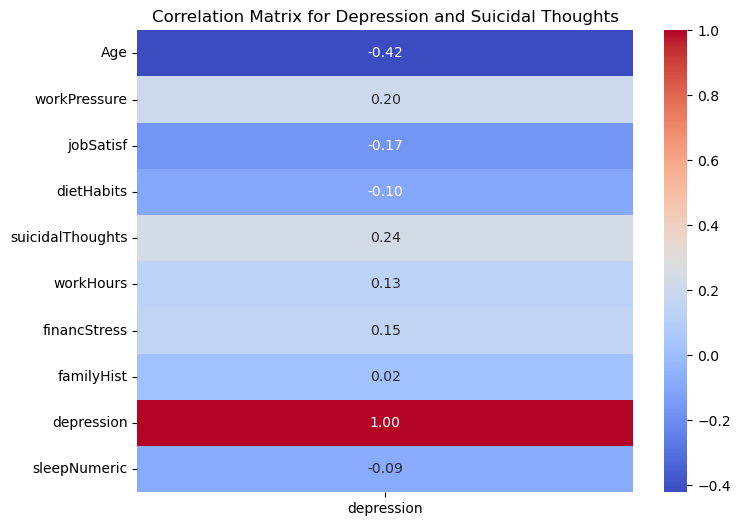

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = depression_df.drop(columns= ['Gender','sleepDuration'], inplace = False).corr()

correlation_of_interest = correlation_matrix[['depression']]

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_of_interest, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    cbar=True
)

plt.title('Correlation Matrix for Depression and Suicidal Thoughts')
plt.show()

As correlações não são muito favoráveis dessa forma. Há, como demonstrado, poucos casos assinalados como depressão no dataset:

In [212]:
casos_depressao = len(depression_df.loc[depression_df['depression'] == 1])
total_respostas = len(depression_df)

print(casos_depressao/total_respostas)

0.0988315481986368


Como nossa intenção é encontrar casos não reportados de depressão, faremos o balanceamento do banco de dados, dividindo igualmente partes com e sem depressão.

In [213]:
import pandas as pd
from sklearn.utils import resample

depression_present = depression_df[depression_df['depression'] == 1]
depression_absent = depression_df[depression_df['depression'] == 0]

depression_absent_downsampled = resample(
    depression_absent,
    replace=False, 
    n_samples=len(depression_present), 
    random_state=42
)

depression_balanced_df = pd.concat([depression_present, depression_absent_downsampled]).sample(frac=1, random_state=42)

Agora, vendo essa matriz de correlação:

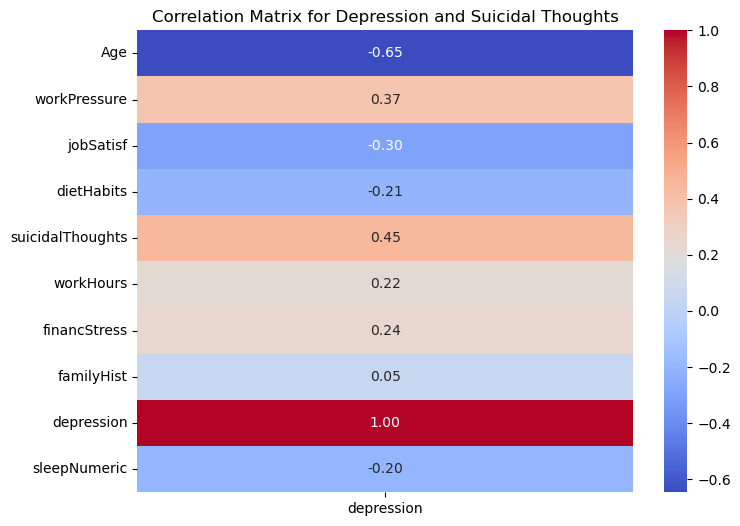

In [214]:
correlation_matrix = depression_balanced_df.drop(columns= ['Gender','sleepDuration'], inplace = False).corr()

correlation_of_interest = correlation_matrix[['depression']]

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_of_interest, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    cbar=True
)

plt.title('Correlation Matrix for Depression and Suicidal Thoughts')
plt.show()

Bem mais simples!

## Training and testing

Vamos agora transformar as features categóricas em um formato mais simples de trabalhar. Simplesmente criaremos uma coluna para cada categoria, que servirá de indicação para o algorítmo.

(Atenção: Rodar apenas uma vez!)

In [215]:
depression_df['less5hSleep'] = (depression_df['sleepDuration'] == 'Less than 5 hours').astype(int)
depression_df['5h6hSleep'] = (depression_df['sleepDuration'] == '5-6 hours').astype(int)
depression_df['7h8hSleep'] = (depression_df['sleepDuration'] == '7-8 hours').astype(int)
depression_df['more8hSleep'] = (depression_df['sleepDuration'] == 'More than 8 hours').astype(int)

depression_df = depression_df.drop(columns="sleepDuration")

In [216]:
depression_df['isMale'] = (depression_df['Gender'] == 'Male').astype(int)
depression_df['isFemale'] = (depression_df['Gender'] == 'Female').astype(int)

depression_df = depression_df.drop(columns="Gender")

E é importante fazer o mesmo pro dataset balanceado:

In [217]:
depression_balanced_df['less5hSleep'] = (depression_balanced_df['sleepDuration'] == 'Less than 5 hours').astype(int)
depression_balanced_df['5h6hSleep'] = (depression_balanced_df['sleepDuration'] == '5-6 hours').astype(int)
depression_balanced_df['7h8hSleep'] = (depression_balanced_df['sleepDuration'] == '7-8 hours').astype(int)
depression_balanced_df['more8hSleep'] = (depression_balanced_df['sleepDuration'] == 'More than 8 hours').astype(int)

depression_balanced_df = depression_balanced_df.drop(columns="sleepDuration")

In [218]:
depression_balanced_df['isMale'] = (depression_balanced_df['Gender'] == 'Male').astype(int)
depression_balanced_df['isFemale'] = (depression_balanced_df['Gender'] == 'Female').astype(int)

depression_balanced_df = depression_balanced_df.drop(columns="Gender")

Indo para o modelo. Abaixo, testaremos diversos modelos, para selecionar o melhor. Estamos utilizando tanto acuracia quanto score F1 para determinar a qualidade dos resultados.

In [219]:
from sklearn.model_selection import train_test_split

X = depression_df.drop(columns='depression')
y = depression_df['depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

               F1-Score  Accuracy
Random Forest  0.942066  0.949757
Decision Tree  0.926261  0.927066
SVM            0.855846  0.901135
kNN            0.918937  0.925446
XGBoost        0.970993  0.972447


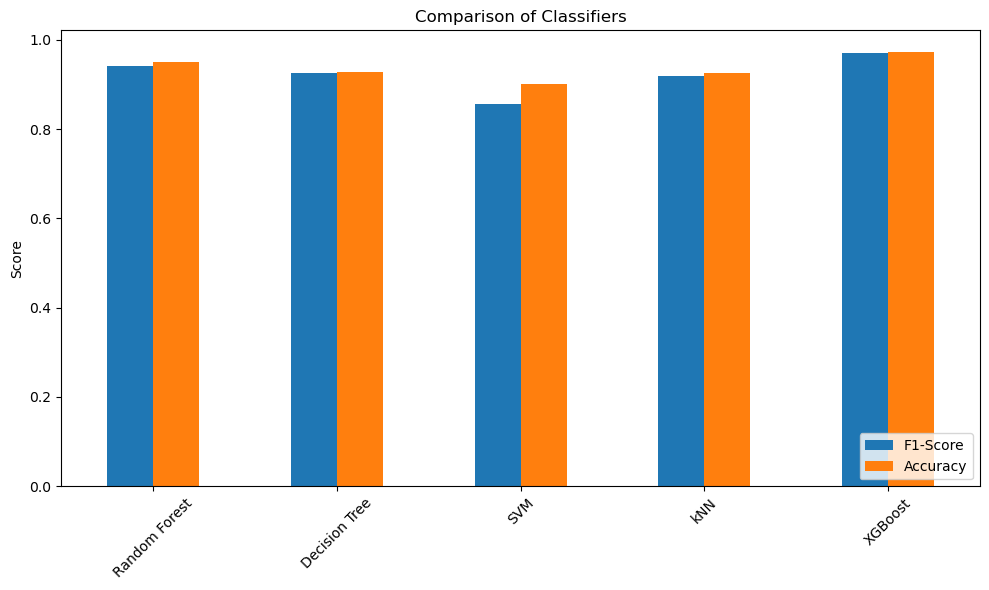

In [220]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {'F1-Score': f1, 'Accuracy': accuracy}

results_df = pd.DataFrame(results).T

print(results_df)

results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Comparison of Classifiers")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Como a diferença entre o modelo RandomForest e o modelo XGBoost é muito pequena, decidi utilizar RandomForest, pela capacidade de customização simplificada.

In [221]:
X_balanced = depression_balanced_df.drop(columns='depression')
y_balanced = depression_balanced_df['depression']

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

metrics = classification_report(y_test, clf.predict(X_test))

X_original = depression_df.drop(columns=['depression'])
y_original = depression_df['depression']

depression_df['risk_score'] = clf.predict_proba(X_original)[:, 1]

high_risk_no_depression = depression_df[
    (depression_df['depression'] == 0) & (depression_df['risk_score'] > 0.75)
]

high_risk_no_depression = high_risk_no_depression.sort_values(by='risk_score', ascending=False)

Nesse código também testamos o modelo e fizemos nossas predições finais. Criamos um dataset extra para guardar esses casos.

Podemos visualizar os resultados:

Classification Metrics:
               precision    recall  f1-score   support

           0       0.86      0.93      0.90        46
           1       0.96      0.91      0.93        76

    accuracy                           0.92       122
   macro avg       0.91      0.92      0.91       122
weighted avg       0.92      0.92      0.92       122


High-Risk Individuals:


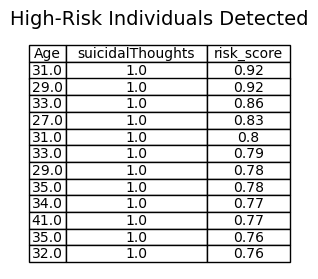

In [222]:
def plot_table(data, title, figsize=(10, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=data.values,
        colLabels=data.columns,
        cellLoc='center',
        loc='center',
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(data.columns))))
    plt.title(title, fontsize=14, pad=10)
    plt.show()

print("Classification Metrics:\n", metrics)

if not high_risk_no_depression.empty:
    print("\nHigh-Risk Individuals:")
    plot_table(high_risk_no_depression[['Age', 'suicidalThoughts','risk_score']].round(2), "High-Risk Individuals Detected", figsize=(2, 3))
else:
    print("No high-risk individuals detected.")

Como visto, temos individuos com mais alto risco, e todos eles já tiveram pensamentos suicidas!